In [1]:
# Setup (PyTorch, paths, device, seeds)
import os, random, math, time
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms ,models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
import tempfile

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_fscore_support
torch.manual_seed(42)

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# Use the returned path to set base_dir correctly
base_dir = os.path.join(path, "chest_xray")
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

In [3]:
print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)

print("Train dir contents:", os.listdir(train_dir))
print("Val dir contents:", os.listdir(val_dir))
print("Test dir contents:", os.listdir(test_dir))

Train dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train
Val dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val
Test dir: /Users/daniel/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test
Train dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']
Val dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']
Test dir contents: ['.DS_Store', 'PNEUMONIA', 'NORMAL']


In [ ]:
# Datasets, DataLoaders, class weights (for imbalance)
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 4

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

train_ds = datasets.ImageFolder(train_dir, transform=transform)
val_ds   = datasets.ImageFolder(val_dir,   transform=transform)
test_ds  = datasets.ImageFolder(test_dir,  transform=transform)

print("Classes:", train_ds.classes, "=>", train_ds.class_to_idx)

In [ ]:
# CNN model as a class (__init__ + forward)
class PneumoCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(PneumoCNN, self).__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        m = models.resnet18(weights=weights)
        m.fc = nn.Linear(m.fc.in_features, 1)
        self.net = m

    def forward(self, x):
        return self.net(x).squeeze(1)  # [B]

In [ ]:
model = PneumoCNN(num_classes=1)
model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)
model = model.to(device)
EPOCHS = 15
patience = int(EPOCHS * 2/3)
lr = 1e-3

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [ ]:
# Compute class weights for BCEWithLogitsLoss (pos_weight = N_neg / N_pos for label=1 class)
# In ImageFolder, NORMAL -> 0, PNEUMONIA -> 1 (alphabetical)
train_targets = torch.tensor([y for _, y in train_ds.samples])
pos = (train_targets==1).sum().item()
neg = (train_targets==0).sum().item()
pos_weight = torch.tensor([neg / max(pos,1.0)], dtype=torch.float32)
print(f"Train counts -> NEG(NORMAL)={neg}, POS(PNEUMONIA)={pos}, pos_weight={pos_weight.item():.3f}")

In [ ]:
# # Loss, Optimizer, LR scheduler
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))  # robust for class imbalance
optimizer = AdamW(model.parameters(), lr=lr)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True) # monitors val accuracy

In [ ]:
# Utilities: train/eval loops
def accuracy_from_logits(logits, targets):
    probs = torch.sigmoid(logits).squeeze(1)
    preds = (probs >= 0.5).long()
    correct = (preds == targets.long()).sum().item()
    return correct, preds, probs

def run_one_epoch(model, loader, epochNumber, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    epoch_loss = 0.0
    correct = 0
    n = 0
    all_probs, all_targets = [], []

    for images, targets in tqdm(loader, desc=f"Epoch {epochNumber}/{EPOCHS}"):
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.set_grad_enabled(is_train):
            logits  = model(images)
            if logits.ndim == 2 and logits.size(1) == 1:
                logits = logits[:, 0]
            targets = targets.float().view(-1)
            loss = criterion(logits, targets)
            if is_train:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

        c, _, probs = accuracy_from_logits(logits.unsqueeze(1), targets)
        epoch_loss += loss.item() * images.size(0)
        correct += c
        n += images.size(0)

        all_probs.append(probs.detach().cpu())
        all_targets.append(targets.detach().cpu())

    avg_loss = epoch_loss / n
    acc = correct / n
    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # Some environments may lack enough positive/negative samples for AUC early on; guard it
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except Exception:
        auc = float('nan')

    return avg_loss, acc, auc, all_probs, all_targets

In [ ]:
# CTraining over epochs with early stopping + checkpoint
best_val_acc = -np.inf
no_improve = 0
ckpt_path = "best_cnn_pneumonia.pt"

history = {"train_loss":[], "train_acc":[], "train_auc":[],
           "val_loss":[], "val_acc":[], "val_auc":[]}

start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_auc, _, _ = run_one_epoch(model, train_loader, epoch, optimizer)
    va_loss, va_acc, va_auc, _, _ = run_one_epoch(model, val_loader, epoch, optimizer=None)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc); history["train_auc"].append(tr_auc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc);   history["val_auc"].append(va_auc)

    # scheduler.step(va_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train: loss {tr_loss:.4f} acc {tr_acc:.4f} auc {tr_auc:.4f} | "
          f"Val:   loss {va_loss:.4f} acc {va_acc:.4f} auc {va_auc:.4f}")

    # Early stopping & checkpoint
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        no_improve = 0
        torch.save({"model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "epoch": epoch}, ckpt_path)
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

print(f"Training finished in {(time.time()-start)/60:.1f} min. Best val acc: {best_val_acc:.4f}")

In [ ]:
# Load best checkpoint (optional) and plot curves
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])

def plot_curves(h):
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    axs[0].plot(h["train_loss"], label="train"); axs[0].plot(h["val_loss"], label="val")
    axs[0].set_title("Loss"); axs[0].legend()
    axs[1].plot(h["train_acc"], label="train"); axs[1].plot(h["val_acc"], label="val")
    axs[1].set_title("Accuracy"); axs[1].legend()
    axs[2].plot(h["train_auc"], label="train"); axs[2].plot(h["val_auc"], label="val")
    axs[2].set_title("ROC-AUC"); axs[2].legend()
    plt.show()

plot_curves(history)

Epoch 1/30:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/30: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


test pres (first 10): [0.00598065 0.7031069  0.76346755 0.9545062  0.09586402 0.01058689
 0.02363181 0.9865509  0.886399   0.030605  ]
TEST — loss: 0.5222 | acc: 0.8510 | auc: 0.9451
Confusion Matrix:
 [[148  86]
 [  7 383]]

Classification Report:
               precision    recall  f1-score   support

      NORMAL     0.9548    0.6325    0.7609       234
   PNEUMONIA     0.8166    0.9821    0.8917       390

    accuracy                         0.8510       624
   macro avg     0.8857    0.8073    0.8263       624
weighted avg     0.8685    0.8510    0.8427       624



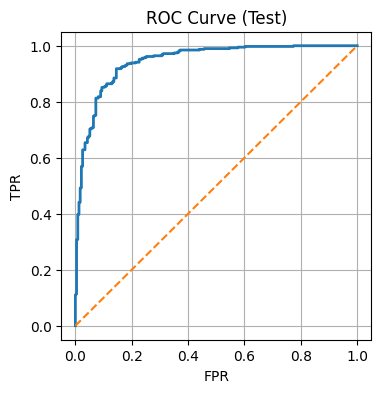

In [13]:
# Final test evaluation + confusion matrix, precision/recall/F1
test_loss, test_acc, test_auc, probs, targets = run_one_epoch(model, test_loader, 1, optimizer=None)
print(f"test pres (first 10): {probs[:10]}")
## TODO: consider using a threshold other than 0.5
preds = (probs >= 0.5).astype(int)

print(f"TEST — loss: {test_loss:.4f} | acc: {test_acc:.4f} | auc: {test_auc:.4f}")

cm = confusion_matrix(targets, preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n",
      classification_report(targets, preds, target_names=test_ds.classes, digits=4))

# Quick ROC curve
fpr, tpr, _ = roc_curve(targets, probs)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve (Test)')
plt.grid(True); plt.show()

In [14]:
# Inference helper (predict on a few samples)
from PIL import Image

def predict_image(path, model, tfms=transform):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = tfms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logit = model(x)
        prob = torch.sigmoid(logit).item()
    pred = int(prob >= 0.5)
    return prob, pred  # probability of PNEUMONIA, predicted label (0 normal / 1 pneumonia)

# Example:
# p, yhat = predict_image(os.path.join(test_dir, "PNEUMONIA", os.listdir(os.path.join(test_dir,"PNEUMONIA"))[0]), model)
# print(p, yhat)


In [15]:
# TODO: consider adding Visualizations like the R3